# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Authors*: J.-G. Young <jgyou@umich.edu> S. Dritz <sjdritz@ucdavis.edu> <br/>
*Date*: April 2022 <br/>

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_pystan3 as pp
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [2]:
M = np.loadtxt('example_matrix.txt').astype('int')
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

Let's visualize it:

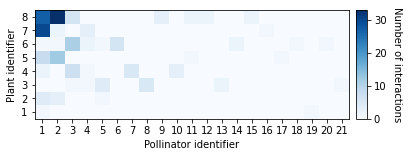

In [3]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [4]:
with open('model_pystan3.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  array[n_p, n_a] int<lower=0> M;
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  array[n_p] int M_rows = rep_array(0, n_p);
  array[n_a] int M_cols = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C 

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [5]:
model = pp.compile_stan_model(M, random_seed = 1)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_4j_g7msh/model_xqidlx7c.stan', line 42, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.


[Compiling]


Warnings about our parameters having no priors can be ignored because when no priors are specified, the model automatically uses uniform priors.

## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [ ]:
samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

We can see by plotting the value of the posterior distribution, evaluated for each samples, that at least one chain has gotten stuck in a minima.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

In [ ]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

In this particular case, one chain has gotten stuck in an optima with lower posterior probability.

We'll re-run the sampling until we get a clean sample:

In [ ]:
while not pp.test_samples(samples, tol=0.05):
    model = pp.compile_stan_model(M)
    samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

After a few attempts we find a nice set of samples:

In [ ]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

Here's the summary of our succesful sampling procedure:

In [ ]:
samples.to_frame()

We now have well-behaved samples, let's move on to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [ ]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

In [ ]:
plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

In [ ]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

In [ ]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [ ]:
edge_prob = pp.estimate_network(samples)

In [ ]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


The parameters themselves are contained in the `samples` object:

In [ ]:
samples['rho']

So we can, for example, visualize posterior distributions as:

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

And find posterior averages with:

In [ ]:
print('Posterior average of the connectance:', np.mean(samples['rho'][0], axis=0))

The same thing goes for, say, the plant abundances (now a dimension `n_p * samples` object---hence why we average along the axis 1, the `samples` axis):

In [ ]:
mean_sigma = np.mean(samples['sigma'], axis=1)

In [ ]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [ ]:
mean_tau = np.mean(samples['tau'], axis=1)

In [ ]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [ ]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [ ]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://www.biorxiv.org/content/10.1101/754077v1)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
bioRxiv:754077 (2019)


Or get in touch at <jgyou@umich.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!